In [1]:
from collections import OrderedDict
from copy import deepcopy
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import panel as pn
import plotly.colors as pc
import plotly.express as px
import seaborn as sns
import torch
import torch.nn.functional as F
import torch.nn.utils.parametrize as parametrize
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import procrustes
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.random_projection import GaussianRandomProjection
from torch import nn
from torch.utils.data import Subset

from koopmann import aesthetics
from koopmann.data import (
    DatasetConfig,
    create_data_loader,
    get_dataset_class,
)
from koopmann.models import MLP, Autoencoder, ExponentialKoopmanAutencoder
from koopmann.models.layers import LinearLayer
from koopmann.models.utils import get_device, pad_act, parse_safetensors_metadata
from koopmann.utils import compute_model_accuracy

%load_ext autoreload
%autoreload 2

In [2]:
model_name = "lotusroot_model"
scale_idx = 1
k = 100
dim = 20

In [3]:
model_file_path = f"/home/gs4133/koopmann/model_saves/{model_name}.safetensors"
# ae_file_path = f"/home/nsa325/work/koopmann/model_saves/scaling/k_{k}_dim_{dim}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"

ae_file_path = (
    f"/home/gs4133/koopmann/model_saves/scaling/k_{k}_dim_{dim}_loc_{scale_idx}_autoencoder_{model_name}.safetensors"
)

In [4]:
# Dataset config
metadata = parse_safetensors_metadata(file_path=model_file_path)
dataset_config = DatasetConfig(
    dataset_name=metadata["dataset"],
    num_samples=3_000,
    split="train",
    seed=42,
)
DatasetClass = get_dataset_class(name=dataset_config.dataset_name)
train_dataset = DatasetClass(config=dataset_config)

In [6]:
# Load models
model, _ = MLP.load_model(model_file_path)
model.eval()

try:
    autoencoder, ae_metadata = ExponentialKoopmanAutencoder.load_model(ae_file_path)
except KeyError as err:
    # Check if the error is caused by a missing "batchnorm" key
    if str(err) == "'batchnorm'":
        # Re-read the metadata and provide a default value for "batchnorm"
        from ast import literal_eval
        from koopmann.models.autoencoder import parse_safetensors_metadata, load_model, get_device
        
        # Parse metadata from file
        ae_metadata = parse_safetensors_metadata(file_path=ae_file_path)
        # If "batchnorm" is missing, set it to a default value (e.g., False)
        if "batchnorm" not in ae_metadata:
            ae_metadata["batchnorm"] = "False"
        
        # Now create the autoencoder manually with the patched metadata
        autoencoder = ExponentialKoopmanAutencoder(
            input_dimension=literal_eval(ae_metadata["input_dimension"]),
            latent_dimension=literal_eval(ae_metadata["latent_dimension"]),
            nonlinearity=ae_metadata["nonlinearity"],
            k=literal_eval(ae_metadata["steps"]),
            batchnorm=literal_eval(ae_metadata["batchnorm"]),
            hidden_configuration=literal_eval(ae_metadata["hidden_configuration"])
        )
        # Load the weights using your typical loading function
        load_model(autoencoder, ae_file_path, device=get_device(), strict=True)
    else:
        raise  # re-raise the error if it's not due to missing "batchnorm"

autoencoder.eval()


ExponentialKoopmanAutencoder(
  (random_projections): ParameterDict()
  (_encoder): Sequential(
    (0): LinearLayer(
      (layers): Sequential(
        (linear): Linear(in_features=10, out_features=20, bias=True)
        (nonlinearity): LeakyReLU(negative_slope=0.01)
      )
    )
    (1): LinearLayer(
      (layers): Sequential(
        (linear): Linear(in_features=20, out_features=20, bias=True)
        (nonlinearity): LeakyReLU(negative_slope=0.01)
      )
    )
  )
  (_koopman_matrix): LinearLayer(
    (layers): Sequential(
      (linear): ParametrizedLinear(
        in_features=20, out_features=20, bias=False
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): MatrixExponential()
          )
        )
      )
    )
  )
  (_decoder): Sequential(
    (0): LinearLayer(
      (layers): Sequential(
        (linear): Linear(in_features=20, out_features=20, bias=True)
        (nonlinearity): LeakyReLU(negative_slope=0.01)
      )
    )
    

In [8]:
# # Load models
# model, _ = MLP.load_model(model_file_path)
# _ = model.eval()

# # autoencoder, ae_metadata = Autoencoder.load_model(ae_file_path)
# autoencoder, ae_metadata = ExponentialKoopmanAutencoder.load_model(ae_file_path)
# _ = autoencoder.eval()

In [7]:
print(autoencoder.koopman_matrix.linear_layer.weight.data)

tensor([[ 1.0025e+00,  1.3758e-03, -3.1496e-03, -1.7577e-03, -2.6615e-03,
         -3.3043e-03, -5.9349e-03,  3.8959e-03, -1.0710e-02, -1.5546e-02,
          8.1359e-03, -5.1533e-03, -5.8526e-04, -7.5919e-03,  2.0112e-03,
         -1.5594e-03, -2.3800e-03,  8.5071e-04,  8.4788e-03,  1.1074e-02],
        [-1.1698e-03,  1.0071e+00, -3.6675e-03,  1.2259e-03,  3.8057e-03,
          3.8101e-03, -6.5721e-03, -3.9325e-03,  4.8026e-03, -3.9371e-03,
          6.2461e-03,  7.1361e-03, -1.2778e-03, -7.9851e-03,  9.7553e-03,
          2.3363e-04, -1.2344e-03,  8.0872e-04, -7.3883e-03,  1.7741e-02],
        [ 3.0465e-04, -4.5021e-04,  1.0024e+00, -1.4734e-03, -7.4657e-04,
          5.0820e-03, -8.1611e-05,  2.3614e-03,  4.1331e-03, -1.6986e-03,
         -6.8991e-03, -4.1969e-03,  3.5313e-03, -9.7561e-04, -2.4688e-03,
         -1.6110e-03,  5.5900e-03, -5.5277e-03, -2.4160e-03, -1.0444e-02],
        [-3.4444e-03, -6.5215e-03,  3.6699e-04,  1.0176e+00, -3.2777e-04,
          3.1875e-03, -1.1397e-03, 

In [9]:

# Extract the Koopman matrix as a NumPy array
K = autoencoder.koopman_matrix.linear_layer.weight.data.cpu().numpy()

# Perform SVD
U, S, Vt = np.linalg.svd(K)

# Print results
print("U (Left Singular Vectors):")
print(U)

print("\nΣ (Singular Values, Diagonal Matrix):")
print(np.diag(S))

print("\nV^T (Right Singular Vectors Transposed):")
print(Vt)

# Verify decomposition
K_reconstructed = U @ np.diag(S) @ Vt
print("\nReconstruction error:", np.linalg.norm(K - K_reconstructed))


U (Left Singular Vectors):
[[-3.86238880e-02  1.10159442e-01  2.92912185e-01 -1.90134600e-01
   2.62269586e-01 -1.31993979e-01  3.46253216e-01  2.29697689e-01
   1.44398928e-01 -9.31408331e-02 -4.58033346e-02 -3.35424058e-02
   3.91892642e-01 -5.96504509e-01 -2.70383265e-02 -2.16127932e-01
  -4.24342491e-02 -6.63158894e-02 -3.31610143e-02 -9.31507200e-02]
 [-3.72355938e-01  9.11698565e-02 -1.34367824e-01 -3.42723019e-02
   1.83385253e-01  3.33724409e-01  3.20376456e-02 -2.43898667e-02
  -2.85075661e-02  2.47250050e-01  3.11666995e-01  1.76809415e-01
   2.37941474e-01  1.60271838e-01  1.39063578e-02 -1.69436827e-01
   4.85711664e-01 -1.09256923e-01 -3.36784214e-01 -1.56081215e-01]
 [ 7.70254806e-02 -1.10423565e-01 -1.95166349e-01  4.33345258e-01
   1.85620934e-01 -1.91673607e-01  2.94719458e-01 -1.60796680e-02
  -1.32288756e-02  9.80462506e-03  3.84577006e-01  8.85811523e-02
  -1.78973079e-01 -2.39487052e-01  3.46747756e-01  1.11886516e-01
   5.70047647e-04  3.88277382e-01 -2.10335538e-

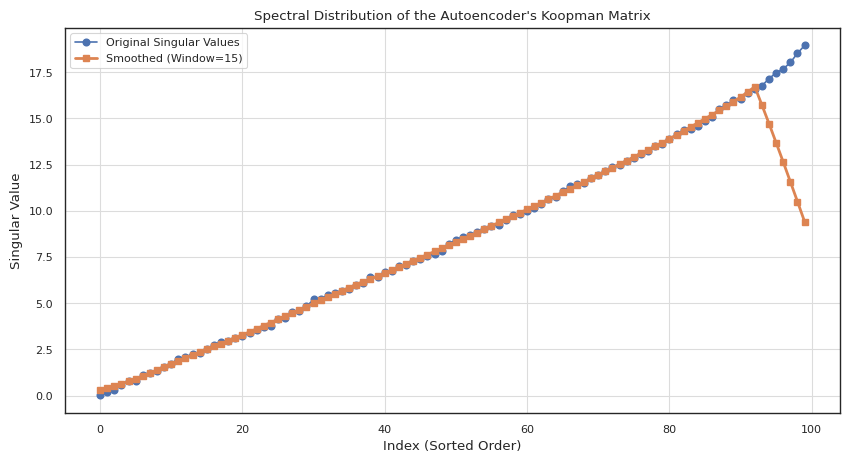

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Extract K from your autoencoder (already done):
# K = autoencoder.koopman_matrix.linear_layer.weight.data.cpu().numpy()

# Step 1: Compute singular values of K
singular_values = np.linalg.svd(K, compute_uv=False)

# Optionally sort the singular values for a more organized plot.
singular_values_sorted = np.sort(singular_values)

# Step 2: Create a uniform moving average kernel of length 15
window_size = 15
kernel = np.ones(window_size) / window_size

# Apply convolution to smooth out the singular values.
smoothed_singular_values = np.convolve(singular_values_sorted, kernel, mode='same')

# Step 3: Plot the original and smoothed singular values
plt.figure(figsize=(10, 5))
plt.plot(singular_values_sorted, 'o-', label='Original Singular Values')
plt.plot(smoothed_singular_values, 's-', label='Smoothed (Window=15)', linewidth=2)
plt.xlabel("Index (Sorted Order)")
plt.ylabel("Singular Value")
plt.title("Spectral Distribution of the Autoencoder's Koopman Matrix")
plt.legend()
plt.grid(True)
plt.show()


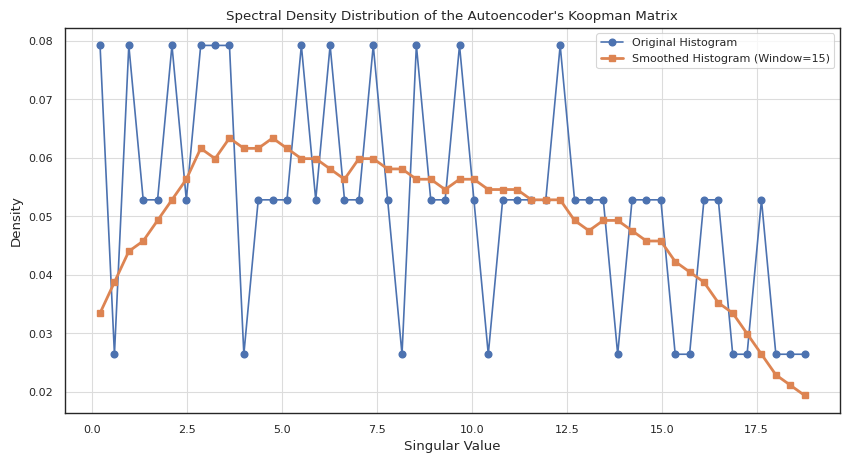

In [13]:
# Compute histogram of the singular values
num_bins = 50  # Adjust the number of bins as needed
hist, bin_edges = np.histogram(singular_values_sorted, bins=num_bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Smooth the histogram using a moving average with a window of 15
smoothed_hist = np.convolve(hist, kernel, mode='same')

# Plotting the original and smoothed histogram densities
plt.figure(figsize=(10, 5))
plt.plot(bin_centers, hist, label='Original Histogram', marker='o')
plt.plot(bin_centers, smoothed_hist, label='Smoothed Histogram (Window=15)', marker='s', linewidth=2)
plt.xlabel("Singular Value")
plt.ylabel("Density")
plt.title("Spectral Density Distribution of the Autoencoder's Koopman Matrix")
plt.legend()
plt.grid(True)
plt.show()


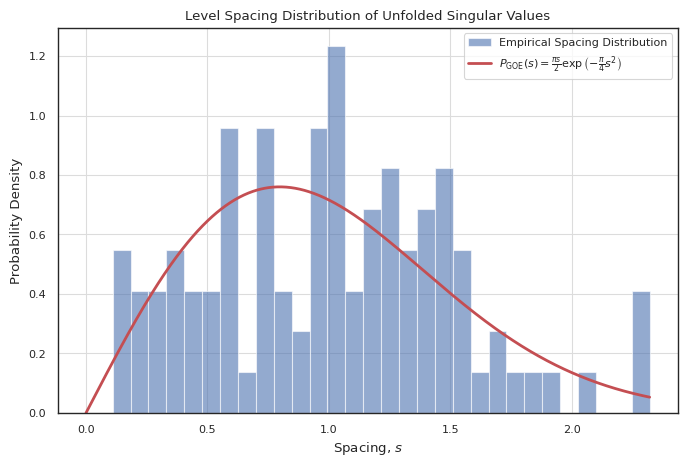

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Step 0: Assume K is already obtained from your autoencoder,
# for instance:
# K = autoencoder.koopman_matrix.linear_layer.weight.data.cpu().numpy()

# Step 1: Compute the singular values and sort them
singular_values = np.linalg.svd(K, compute_uv=False)
singular_values_sorted = np.sort(singular_values)

# Step 2: Unfold the spectrum using a polynomial fit
# Create level indices for the sorted singular values
N = len(singular_values_sorted)
indices = np.arange(1, N + 1)

# Fit a low-degree polynomial (here degree 3) to map singular values to level indices:
poly_degree = 3
poly_coeffs = np.polyfit(singular_values_sorted, indices, deg=poly_degree)

# Evaluate the polynomial to obtain unfolded levels, which are expected to have mean spacing 1.
unfolded_levels = np.polyval(poly_coeffs, singular_values_sorted)

# Step 3: Compute level spacings from the unfolded spectrum
spacings = np.diff(unfolded_levels)

# Step 4: Plot the empirical spacing distribution and overlay the GOE prediction
plt.figure(figsize=(8, 5))

# Plot a normalized histogram for the empirical spacing distribution
num_bins = 30  # You can adjust the number of bins as needed
plt.hist(spacings, bins=num_bins, density=True, alpha=0.6, color='b',
         label='Empirical Spacing Distribution')

# Define a range of spacing values for plotting the GOE prediction
s_range = np.linspace(0, np.max(spacings), 1000)

# Updated GOE prediction using the Wigner surmise formula
p_goe = (np.pi * s_range / 2) * np.exp(- (np.pi / 4) * s_range**2)
plt.plot(s_range, p_goe, 'r-', lw=2,
         label=r'$P_{\mathrm{GOE}}(s)=\frac{\pi s}{2}\exp\left(-\frac{\pi}{4}s^2\right)$')

plt.xlabel("Spacing, $s$")
plt.ylabel("Probability Density")
plt.title("Level Spacing Distribution of Unfolded Singular Values")
plt.legend()
plt.grid(True)
plt.show()


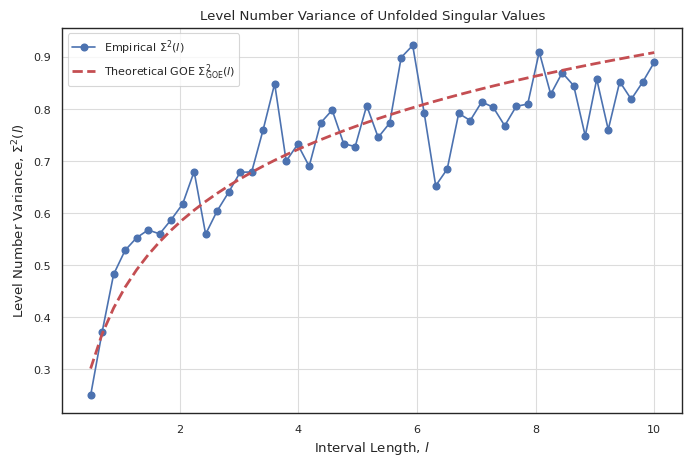

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------
# Step 0: Obtain the weight matrix from your model (assumed already available)
# For example:
# K = autoencoder.koopman_matrix.linear_layer.weight.data.cpu().numpy()

# -----------------------------------------
# Step 1: Compute and sort the singular values
singular_values = np.linalg.svd(K, compute_uv=False)
singular_values_sorted = np.sort(singular_values)

# -----------------------------------------
# Step 2: Unfold the spectrum via polynomial fitting
# Create level indices for the sorted singular values
N = len(singular_values_sorted)
indices = np.arange(1, N + 1)

# Fit a low-degree polynomial; degree 3 is often a good compromise.
poly_degree = 3
poly_coeffs = np.polyfit(singular_values_sorted, indices, deg=poly_degree)

# Evaluate the polynomial to obtain the unfolded levels (should have mean spacing of 1)
unfolded_levels = np.polyval(poly_coeffs, singular_values_sorted)

# -----------------------------------------
# Step 3: Compute the empirical level number variance Σ²(l)
# Define a range of interval lengths l (adjust as needed)
l_vals = np.linspace(0.5, 10, 50)
sigma2_empirical = []

for l in l_vals:
    counts = []
    # Loop over each unfolded level as a starting point.
    for i, x in enumerate(unfolded_levels):
        # Ensure that the interval [x, x+l] lies fully within the spectrum
        if x + l <= unfolded_levels[-1]:
            # Use searchsorted to count levels up to x+l
            j = np.searchsorted(unfolded_levels, x + l, side='right')
            # Count the number of levels in the interval (x, x+l]
            count = j - i - 1  # exclude the starting level
            counts.append(count)
    # Compute the variance over all valid intervals
    if counts:
        counts = np.array(counts)
        sigma2 = np.mean((counts - l)**2)
    else:
        sigma2 = np.nan
    sigma2_empirical.append(sigma2)

sigma2_empirical = np.array(sigma2_empirical)

# -----------------------------------------
# Step 4: Define the theoretical GOE number variance
def sigma2_goe(l):
    # Euler's constant:
    gamma = 0.5772156649
    return (2 / np.pi**2) * (np.log(2 * np.pi * l) + gamma + 1 - (np.pi**2) / 8)

sigma2_theory = sigma2_goe(l_vals)

# -----------------------------------------
# Step 5: Plot the empirical and theoretical level number variance
plt.figure(figsize=(8, 5))
plt.plot(l_vals, sigma2_empirical, 'bo-', label=r'Empirical $\Sigma^2(l)$')
plt.plot(l_vals, sigma2_theory, 'r--', linewidth=2, 
         label=r'Theoretical GOE $\Sigma^2_{\mathrm{GOE}}(l)$')
plt.xlabel("Interval Length, $l$")
plt.ylabel(r"Level Number Variance, $\Sigma^2(l)$")
plt.title("Level Number Variance of Unfolded Singular Values")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# After loading the autoencoder model, add this code to modify the Koopman matrix:

# Remove parametrization if it exists
# if hasattr(autoencoder.koopman_matrix.linear_layer, '_parametrizations'):
parametrize.remove_parametrizations(autoencoder.koopman_matrix.linear_layer, 'weight')

K_new = np_ones(S)

# Update the Koopman matrix
autoencoder.koopman_matrix.linear_layer.weight.data = torch.tensor(K_new, dtype=torch.float32)

# # Verify the changes
print("Modified Koopman matrix shape:", autoencoder.koopman_matrix.linear_layer.weight)

NameError: name 'np_ones' is not defined

In [ ]:
print(autoencoder.koopman_matrix.linear_layer.weight.data)

tensor([[ 9.9978e-01,  1.2657e-03, -1.7145e-03,  9.4471e-04,  3.7633e-04,
          1.1508e-03, -2.9780e-03,  3.2179e-03, -8.2527e-03, -1.0971e-02,
          4.9046e-03, -6.6771e-03,  1.7212e-03, -5.2122e-03, -8.9643e-04,
         -4.7244e-03, -2.9851e-04, -2.2288e-04,  7.7907e-03,  6.1158e-03],
        [-1.4760e-03,  9.9977e-01, -1.4887e-03,  3.6514e-03,  2.7453e-03,
         -1.4160e-03,  2.5024e-03,  2.7589e-03, -1.5984e-03, -6.2184e-03,
          1.5767e-02,  6.1742e-04, -4.6871e-03, -3.8826e-03,  1.1463e-03,
         -5.6536e-03,  3.2151e-03,  6.2522e-03, -2.0108e-04,  2.4459e-03],
        [ 1.7723e-03,  1.5817e-03,  9.9993e-01, -8.7258e-04,  3.1386e-04,
          1.9597e-03, -1.0109e-03,  2.7377e-03,  7.3965e-03,  9.5446e-04,
         -5.9584e-03, -2.9211e-03, -3.3349e-04, -1.8248e-03,  1.4407e-03,
         -2.8268e-03, -9.4717e-04,  8.6830e-04,  2.1545e-05, -2.1144e-03],
        [-8.8595e-04, -3.7839e-03,  9.2698e-04,  9.9980e-01,  1.6412e-03,
          5.9940e-06, -1.7990e-03, 

In [ ]:
metadata

{'bias': 'True',
 'config': '[10, 8, 6, 3]',
 'dataset': 'LotusRootDataset',
 'input_dimension': '2',
 'nonlinearity': 'relu',
 'output_dimension': '2'}

In [ ]:
target_class = 1
idx = torch.where(train_dataset.labels == target_class)[0]
subset = Subset(train_dataset, idx)
loader = torch.utils.data.DataLoader(train_dataset, batch_size=1_000, shuffle=True)
data, labels = next(iter(loader))

In [ ]:
# Compute initial PCA
def compute_reference_bases(data):
    # Compute PCA reference basis
    pca = PCA(n_components=3)
    ref = pca.fit_transform(data)
    return ref


# Function to align using Procrustes from scipy
def align_using_procrustes(reference_points, new_points):
    _, new_points_aligned, _ = procrustes(reference_points, new_points)
    return new_points_aligned


In [ ]:
# Enable Panel for Jupyter
pn.extension()


def create_3d_scatter_plot(data, labels, axis_range):
    x, y, z = data[:, 0], data[:, 1], data[:, 2]

    str_labels = [str(label) for label in labels]
    color = str_labels

    # pca_scalar_field = np.linalg.norm(ref_a, axis=1)
    # color = pca_scalar_field
    # color_continuous_scale="Viridis")
    fig = px.scatter_3d(x=x, y=y, z=z, color=color)

    fig.update_traces(marker=dict(size=1))
    fig.update_layout(
        scene=dict(
            xaxis=dict(range=axis_range),
            yaxis=dict(range=axis_range),
            zaxis=dict(range=axis_range),
            aspectmode="cube",
            aspectratio=dict(x=1, y=1, z=1),
        ),
        showlegend=False,
    )
    return fig


def process_pca_and_align(data, reference):
    """Applies PCA, aligns using Procrustes, and returns aligned data."""
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(data)
    aligned_result = align_using_procrustes(reference, pca_result)
    return aligned_result


def update_plots(data_a, data_b, ref_a, ref_b, labels):
    """Updates PCA and RP plots with the given data and references."""
    pca_axis_range = [-0.05, 0.05]  # Default axis range

    # First plot: PCA
    aligned_pca_result = process_pca_and_align(data_a, ref_a)
    first_fig = create_3d_scatter_plot(aligned_pca_result, labels, pca_axis_range)

    # Second plot: PCA
    aligned_pca_result = process_pca_and_align(data_b, ref_b)
    second_fig = create_3d_scatter_plot(aligned_pca_result, labels, pca_axis_range)

    return first_fig, second_fig


# Clone and hook model
cloned_model = deepcopy(model)
cloned_model.hook_model()

# Activations from original model
with torch.no_grad():
    _ = cloned_model.forward(data)
act_dict = cloned_model.get_fwd_activations(detach=True)

# Get Koopman predictions
k = int(ae_metadata["num_scaled"])
new_keys = list(range(0, k + 1))
decoded_act = autoencoder(x=act_dict[0], k=k, intermediate=True).predictions.detach().numpy()
decoded_act_dict = OrderedDict(zip(new_keys, decoded_act))
ref_decoded = compute_reference_bases(decoded_act_dict[0])

# Get observable predictions
embedded_act = [autoencoder.encoder(act_dict[0])] * (k + 1)
embedded_act = [
    act if i == 0 else reduce(lambda x, _: autoencoder.koopman_matrix(x), range(i), act)
    for i, act in enumerate(embedded_act)
]
embedded_act = [act.detach().numpy() for act in embedded_act]
embedded_act_dict = OrderedDict(zip(new_keys, embedded_act))
ref_embedded = compute_reference_bases(embedded_act[0])

# Create slider
layer_select = pn.widgets.IntSlider(name="Layer Selector", start=0, end=k, step=1, value=0)


@pn.depends(layer_select.param.value)
def view(layer_index):
    figs = update_plots(
        decoded_act_dict[layer_index],
        embedded_act_dict[layer_index],
        ref_decoded,
        ref_embedded,
        labels,
    )
    panes = [pn.pane.Plotly(fig) for fig in figs]

    return pn.Row(*panes, align="center")


# Layout
layout = pn.Column(
    pn.Row(layer_select, align="center"),
    view,
    align="center",
    sizing_mode="stretch_width",
)

layout.show()

Launching server at http://localhost:36691
